<a href="https://colab.research.google.com/github/ju-arauj/Projeto_Aplicado_II/blob/main/Projeto_Aplicado_2_An%C3%A1lise_de_Sentimento.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto Aplicado 2

#Construindo um modelo capaz de classificar as avaliações dos consumidores dos produtos de skin care da Sephora como positivas ou negativas.

##Descrição dos metadados

**author_id**: O identificador do autor da avaliação no site.  
**rating**: A nota dada pelo autor para o produto em uma escala de 1 a 5.  
**is_recommended**: Indica se o autor recomenda o produto ou não (1-verdadeiro, 0-falso).  
**helpfulness**: A proporção de todas as avaliações em relação às avaliações positivas para a resenha: helpfulness = total_pos_feedback_count / total_feedback_count.  
**total_feedback_count**: O número total de feedbacks (avaliações positivas e negativas) deixados pelos usuários para a resenha.  
**total_neg_feedback_count**: O número de usuários que deram uma avaliação negativa para a resenha.  
**total_pos_feedback_count**: O número de usuários que deram uma avaliação positiva para a resenha.  
**submission_time**: Data em que a avaliação foi publicada no site no formato 'aaaa-mm-dd'.  
**review_text**: O texto principal da resenha escrito pelo autor.  
**review_title**: O título da resenha escrito pelo autor.  
**skin_tone**: O tom de pele do autor.
**eye_color**: A cor dos olhos do autor.
**skin_type**: O tipo de pele do autor (ex.: mista, oleosa, etc.).  
**hair_color**: A cor do cabelo do autor (ex.: castanho, ruivo, etc.).  
**product_id**: O identificador único do produto no site.


###Para a construção do nosso modelo classificador de sentimento vamos considerar como variável explicativa a coluna **review_text** e como variável target **is_recommended**.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Importação e análise exploratória da base de dados

In [ ]:
import pandas as pd
import re
import nltk
nltk.download("all")
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
import spacy


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

In [ ]:
dados = pd.read_csv("/content/drive/MyDrive/Mackenzie-Projeto2/reviews_0-250.csv")
display(dados.head())


<ipython-input-3-e1923561d5ce>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dados = pd.read_csv("/content/drive/MyDrive/Mackenzie-Projeto2/reviews_0-250.csv")


,Unnamed: 0,author_id,rating,is_recommended,helpfulness,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,review_title,skin_tone,eye_color,skin_type,hair_color,product_id,product_name,brand_name,price_usd
0,0,1741593524,5,1.0,1.0,2,0,2,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,Taught me how to double cleanse!,NaN,brown,dry,black,P504322,Gentle Hydra-Gel Face Cleanser,NUDESTIX,19.0
1,1,31423088263,1,0.0,NaN,0,0,0,2023-03-21,I bought this lip mask after reading the revie...,Disappointed,NaN,NaN,NaN,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
2,2,5061282401,5,1.0,NaN,0,0,0,2023-03-21,My review title says it all! I get so excited ...,New Favorite Routine,light,brown,dry,blonde,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
3,3,6083038851,5,1.0,NaN,0,0,0,2023-03-20,I’ve always loved this formula for a long time...,Can't go wrong with any of them,NaN,brown,combination,black,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0
4,4,47056667835,5,1.0,NaN,0,0,0,2023-03-20,"If you have dry cracked lips, this is a must h...",A must have !!!,light,hazel,combination,NaN,P420652,Lip Sleeping Mask Intense Hydration with Vitam...,LANEIGE,24.0


In [ ]:
print(f'O dataset tem {dados.shape[0]} linhas e {dados.shape[1]} colunas.')

O dataset tem 602130 linhas e 19 colunas.


In [ ]:
if dados.duplicated().any():
    print("Duplicatas encontradas")
else:
    print("Não foram encontradas duplicatas.")

Não foram encontradas duplicatas.


In [ ]:
# Verificar a estrutura do dataset
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602130 entries, 0 to 602129
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Unnamed: 0                602130 non-null  int64  
 1   author_id                 602130 non-null  object 
 2   rating                    602130 non-null  int64  
 3   is_recommended            484644 non-null  float64
 4   helpfulness               270298 non-null  float64
 5   total_feedback_count      602130 non-null  int64  
 6   total_neg_feedback_count  602130 non-null  int64  
 7   total_pos_feedback_count  602130 non-null  int64  
 8   submission_time           602130 non-null  object 
 9   review_text               601131 non-null  object 
 10  review_title              435119 non-null  object 
 11  skin_tone                 496074 non-null  object 
 12  eye_color                 463642 non-null  object 
 13  skin_type                 527447 non-null  o

####Observamos aqui que há colunas com valores nulos, incluindo a variável **is_recommended**, essencial para a nossa análise de sentimento. Mais adiante, vamos excluir esses dados para adequar a base de dados aos modelos de ML.

In [ ]:
dados.columns


Index(['Unnamed: 0', 'author_id', 'rating', 'is_recommended', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time', 'review_text',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'],
      dtype='object')

####Vamos excluir as colunas que não serão necessárias para a criação do modelo. Precisaremos apenas da coluna com as avaliações (review_text) e a coluna com a classificação do sentimento correspondente (is_recommended).

In [ ]:
dados = dados.drop(columns=['Unnamed: 0', 'author_id', 'rating', 'helpfulness',
       'total_feedback_count', 'total_neg_feedback_count',
       'total_pos_feedback_count', 'submission_time',
       'review_title', 'skin_tone', 'eye_color', 'skin_type', 'hair_color',
       'product_id', 'product_name', 'brand_name', 'price_usd'])
dados.head()

,is_recommended,review_text
0,1.0,I use this with the Nudestix “Citrus Clean Bal...
1,0.0,I bought this lip mask after reading the revie...
2,1.0,My review title says it all! I get so excited ...
3,1.0,I’ve always loved this formula for a long time...
4,1.0,"If you have dry cracked lips, this is a must h..."


In [ ]:
#removendo as linhas com dados nulos
dados = dados.dropna()
dados.info()

<class 'pandas.core.frame.DataFrame'>
Index: 483645 entries, 0 to 602129
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   is_recommended  483645 non-null  float64
 1   review_text     483645 non-null  object 
dtypes: float64(1), object(1)
memory usage: 11.1+ MB


In [ ]:
print(f'O dataset tem {dados.shape[0]} linhas e {dados.shape[1]} colunas.')

O dataset tem 483645 linhas e 2 colunas.


###Para que o notebook execute todas as células sem transtornos, vamos reduzir a quantidade de observações para 20%, mantendo a proporção de cada classe da variável target.

In [ ]:
df_positivo = dados[dados['is_recommended'] == 1.0]
df_negativo = dados[dados['is_recommended'] == 0.0]

#reduzindo em 80% as observações de cada classe
df_positivo_dropped = df_positivo.sample(frac=0.8, random_state = 20)
df_negativo_dropped = df_negativo.sample(frac=0.8, random_state = 20)

df_positivo = df_positivo.drop(df_positivo_dropped.index)
df_negativo = df_negativo.drop(df_negativo_dropped.index)

#juntando os dois dataframes reduzidos
dados = pd.concat([df_negativo, df_positivo])

print(f'O dataset tem {dados.shape[0]} linhas e {dados.shape[1]} colunas.')

O dataset tem 96729 linhas e 2 colunas.


####Verificando se as classes da variável target estão desbalanceadas

In [ ]:
print(dados.is_recommended.value_counts())

is_recommended
1.0    81047
0.0    15682
Name: count, dtype: int64


<ipython-input-13-2158a3183cfc>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x = 'is_recommended', data=dados, palette='magma')


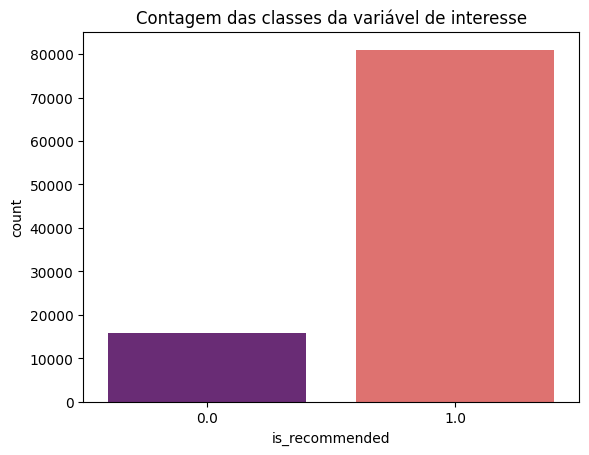

In [ ]:

ax = sns.countplot(x = 'is_recommended', data=dados, palette='magma')
ax.set_title("Contagem das classes da variável de interesse")
plt.show()

####Existe uma diferença significativa entre o número de avaliações classificadas como positivas (1.0) e negativas (0.0). É importante lembrar dessa informação mais adiante, quando montarmos o modelo de classificação, pois precisaremos fazer um tratamento em relação ao desbalanceamento desses dados.

###Criando uma nuvem de palavras para visualizar a frequência das palavras

In [ ]:
pip install wordcloud

In [ ]:
%matplotlib inline

In [ ]:
from wordcloud import WordCloud

In [ ]:
all_words = [text for text in dados.review_text]
print(len(all_words))
all_words[:2]

96729


['I bought this lip mask after reading the reviews and the hype. Unfortunately, it did not meet my expectations as vaseline petroleum jelly works way better for me.',
 'There’s nothing wrong with it but i think it was overhyped on tiktok. It actually made my lips a little dry.']

In [ ]:
all_words_together = "".join(all_words) #gerando uma variável que contém todas as palavras
print(len(all_words_together))

30176815


In [ ]:
word_cloud = WordCloud(width = 800, height = 500, max_font_size = 110).generate(all_words_together)

<function matplotlib.pyplot.show(close=None, block=None)>

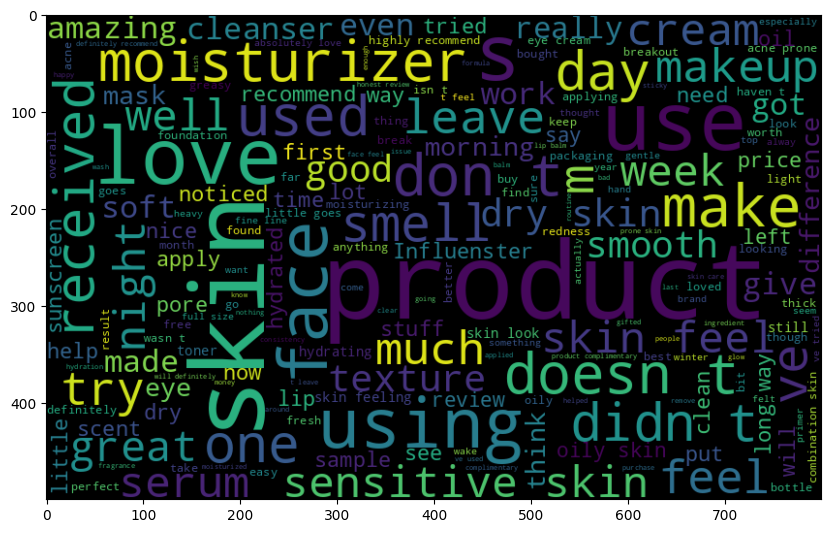

In [ ]:

plt.figure(figsize = (10,8))
plt.imshow(word_cloud, interpolation='bilinear')
plt.show

####Podemos observar que algumas palavras que se destacam não são semanticamente relevantes, pois não trazem informação útil para o modelo (por exemplo, "doesn't"). Também há palavras com a mesma raiz, mas flexionadas de formas diferentes, como "used", "using" e "use", o que deixa nossos dados redundantes. Mais adiante, faremos um tratamento para remover as palavras irrelevantes e reduzir as palavras a sua raiz.

####Agora vamos identificar as palavras mais frequentes na coluna **review_text**.

####Primeiro vamos utilizar a biblioteca NLTK para fazer a tokenização (ou seja, para separar cada palavra das frases, gerando tokens).

####Por que utilizar a NLTK?

####NLTK (Natural Language Toolkit) é uma biblioteca disponível na linguagem Python para realizar projetos de Processamento de Linguagem Natural. Ela disponibiliza um conjunto robusto de ferramentas para fazer o pré-processamento de texto, oferecendo, por exemplo, as stopwords de várias línguas, vetorizadores e ferramentas de lematização.

In [ ]:
from nltk import tokenize

In [ ]:
#Separando as palavras e gerando um dicionário com a frequência de cada palavra
token_space = tokenize.WhitespaceTokenizer() #tokenizando as palavras, utilizando como separador os espaços em branco
token_phrases = token_space.tokenize(all_words_together)
frequence = nltk.FreqDist(token_phrases)

In [ ]:
frequence

FreqDist({'I': 216367, 'and': 196669, 'the': 148380, 'my': 146420, 'a': 145065, 'it': 128192, 'this': 114454, 'to': 104054, 'skin': 84027, 'is': 82378, ...})

In [ ]:
data_frequence = pd.DataFrame({"Word" : list(frequence.keys()), "Frequence": list(frequence.values())})
data_frequence.nlargest(columns="Frequence", n=10)

,Word,Frequence
0,I,216367
9,and,196669
7,the,148380
16,my,146420
41,a,145065
12,it,128192
2,this,114454
66,to,104054
289,skin,84027
60,is,82378


####As palavras mais frequentes são irrelevantes para a análise de sentimento, como "I", "and", "the", "my" etc. (as chamadas *stopwords*). Vamos removê-las na próxima etapa.

##Tratamento da base de dados

####Nesta etapa, vamos realizar os seguintes tratamentos:
* remover stop words
* remover espaços extras do texto
* remover todos os caracteres que não sejam texto
* colocar todas as palavras do dataset em caixa-baixa
* lematizar as palavras

###Removendo palavras irrelevantes (as chamadas **stop words**) e outros elementos inúteis da variável **review_text**

In [ ]:
#imprimindo a lista de stop words da língua inglesa

stop_words = stopwords.words("english")
stop_words

['a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 "he'd",
 "he'll",
 'her',
 'here',
 'hers',
 'herself',
 "he's",
 'him',
 'himself',
 'his',
 'how',
 'i',
 "i'd",
 'if',
 "i'll",
 "i'm",
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it'd",
 "it'll",
 "it's",
 'its',
 'itself',
 "i've",
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'on

In [ ]:
def clean_data(data):
  data = str(data).lower() #colocando todas as letras da base em caixa-baixa

  data = re.sub(r"[^a-zA-Z]", " ", data) #removendo caracteres que não sejam letras
  data = re.sub(r"\s+", " ", data) #caso haja espaços extras, vamos substituí-los por um único espaço

  return data

def remove_stop_words(words): #removendo as stopwords
  filter_words = []
  for i in words:
    if i not in stop_words:
      filter_words.append(i)
  return filter_words

In [ ]:
data_clean = dados.copy() #fazendo uma cópia da base de dados original para realizar o tratamento

In [ ]:
data_clean['review_text'] = data_clean['review_text'].apply(lambda x: clean_data(x))

In [ ]:
data_clean['review_text'][0]

'i use this with the nudestix citrus clean balm make up melt to double cleanse and it has completely changed my skin for the better the make up melt is oil based and removes all of your makeup super easily i follow up with this water based cleanser and i also use this just by itself when i m not wearing make up it leaves the skin gently cleansed but without stripping the skin recommend combining with the make up melt it s perfection '

In [ ]:
data_clean['review_text'] = data_clean['review_text'].apply(lambda x: x.split(" "))

In [ ]:
data_clean['review_text'][1]

['i',
 'bought',
 'this',
 'lip',
 'mask',
 'after',
 'reading',
 'the',
 'reviews',
 'and',
 'the',
 'hype',
 'unfortunately',
 'it',
 'did',
 'not',
 'meet',
 'my',
 'expectations',
 'as',
 'vaseline',
 'petroleum',
 'jelly',
 'works',
 'way',
 'better',
 'for',
 'me',
 '']

In [ ]:
data_clean['review_text'] = data_clean['review_text'].apply(lambda x: remove_stop_words(x))

###Lematizando as palavras
####Fazendo a lematização das palavras, eliminamos qualquer tipo de inflexão, reduzindo-as a sua raiz. Ao contrário do processo de **stemming**, a palavra resultante dessa redução sempre será um termo existente no dicionário. Além disso, nessa técnica, a classe gramatical da palavra será levada em consideração para fazer a redução. Por isso optamos pela **lematização** em vez da técnica de stemming.

In [ ]:
nlp = spacy.load('en_core_web_sm') #como a base de dados que estamos usando está em inglês, vamos importar este modelo de linguagem da biblioteca spacy
data_clean['review_text'] = data_clean['review_text'].apply(lambda x: [token.lemma_ for token in nlp(" ".join(x))])

In [ ]:
data_clean

,is_recommended,review_text
1,0.0,"[buy, lip, mask, reading, review, hype, unfort..."
20,0.0,"[nothing, wrong, think, overhyped, tiktok, act..."
32,0.0,"[really, love, product, use, whole, thing, las..."
42,0.0,"[want, love, product, bad, amazing, review, ho..."
44,0.0,"[waste, money, get, sample, use, direction, sa..."
...,...,...
602105,1.0,"[love, eye, cream, use, many, product, eye, us..."
602110,1.0,"[use, new, triple, algae, eye, renewal, balm, ..."
602115,1.0,"[first, time, try, sort, eye, cream, good, exp..."
602118,1.0,"[usually, skeptical, product, offer, address, ..."


In [ ]:
data_clean['review_text'] = data_clean['review_text'].apply(lambda x: ' '.join(x))

In [ ]:
data_clean.head(10)

,is_recommended,review_text
1,0.0,buy lip mask reading review hype unfortunately...
20,0.0,nothing wrong think overhyped tiktok actually ...
32,0.0,really love product use whole thing last month...
42,0.0,want love product bad amazing review honestly ...
44,0.0,waste money get sample use direction say hydra...
55,0.0,product market sleeping mask would say lip bal...
81,0.0,see hype product work every time use give lip ...
104,0.0,feels smell nice time dry lip lip balm mask ev...
125,0.0,use entire product impress much product dissip...
144,0.0,use course couple night basically lip balm fee...


In [ ]:
data_clean = data_clean.reset_index(drop=True) #como o índice ficou bagunçado depois da concatenação das bases reduzidas, realizada na fase de exploração da base, vamos reordená-lo.

####Feitos os devidos tratamentos, vamos comparar a quantidade de palavras únicas que tínhamos antes com a que temos agora. Para isso, vamos usar o vetorizador CountVectorizer(), que é uma classe da biblioteca Scikit-learn que transforma um corpo de texto em um vetor, basicamente para que o texto fique em uma linguagem que o computador possa compreender.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vectorizer = CountVectorizer() #aplicando o vetorizador, para transformar os textos em matrizes numéricas
vetor = vectorizer.fit_transform(data_clean["review_text"])

#para obtermos o número de palavras únicas
palavras_unicas = vectorizer.get_feature_names_out()

#imprimindo o número de palavras únicas
print(f'Número de palavras únicas da base tratada: {len(palavras_unicas)}')



Número de palavras únicas da base tratada: 21978


In [ ]:
#aplicando o vetorizador, para transformar os textos em matrizes numéricas
vectorizer = CountVectorizer()
vetor1 = vectorizer.fit_transform(dados["review_text"])

#para obtermos o número de palavras únicas
palavras_unicas = vectorizer.get_feature_names_out(vetor1)

#imprimindo o número de palavras únicas
print(f'Número de palavras únicas da base antes do tratamento: {len(palavras_unicas)}')

Número de palavras únicas da base antes do tratamento: 26976


####O número de palavras únicas foi reduzido após a remoção das stopwords e outros elementos desnecessários e a aplicação da técnica da lematização. Isso é importante para construir um modelo com bom desempenho, sem risco de overfitting.

##Construção dos modelos de ML classificadores

### Observação: Como os dados da variável target estão desbalanceados, aplicamos a ténica do **undersampling** para tratá-los e, assim, evitar resultados enviesados nos modelos de classificação utilizados. Aplicando esta técnica, também conhecida como subamostragem, reduzimos aleatoriamente a quantidade de dados da classe majoritária, equilibrando-a com a classe minoritária. Como o undersampling gera perda de informação, não é indicado para datasets que apresentam poucos dados. Neste projeto, porém, estamos lidando com um grande volume de dados, o que permite a utilização da técnica sem prejudicar o desempenho dos modelos de aprendizado de máquina.

##Modelo número 1: Regressão logística

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
vectorizer = CountVectorizer(max_features = 1000) #como a base traz um número grande de dados, vamos testar com 1000 features.
X = vectorizer.fit_transform(data_clean["review_text"]) #vetorizando e separando os dados da variável explicativa
y = data_clean['is_recommended'] #separando os dados da variável target


In [ ]:
from imblearn.under_sampling import RandomUnderSampler

In [ ]:
rus = RandomUnderSampler(random_state = 5)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"Antes: {len(y)} exemplos")
print(f"Depois: {len(y_resampled)} exemplos")

Antes: 96729 exemplos
Depois: 31364 exemplos


In [ ]:
#separando os dados da base em um conjunto de treinamento (com 80% dos dados) e de teste (com 20%)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, shuffle = True, random_state = 8)

regressao_logistica = LogisticRegression()
regressao_logistica.fit(X_train, y_train) #ajustando o modelo aos dados
predictions = regressao_logistica.predict(X_test) #fazendo previsões com os dados de treino da variável explicativa

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.858759764068229


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.87      0.86      3125
         1.0       0.86      0.85      0.86      3148

    accuracy                           0.86      6273
   macro avg       0.86      0.86      0.86      6273
weighted avg       0.86      0.86      0.86      6273



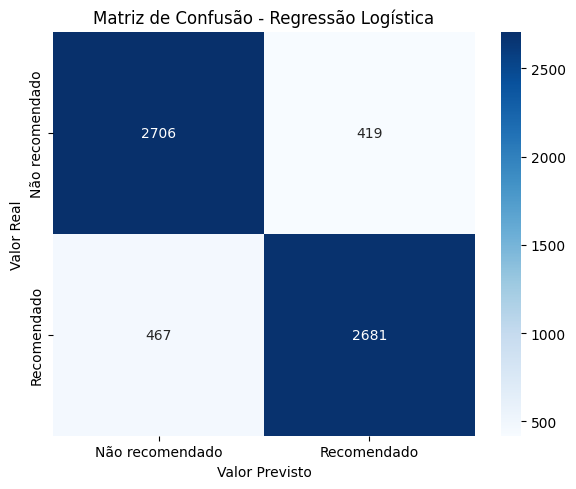

In [ ]:
from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não recomendado", "Recomendado"],
            yticklabels=["Não recomendado", "Recomendado"])
plt.title("Matriz de Confusão - Regressão Logística")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

##Modelo número 2: Random Forest

---



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(data_clean["review_text"])
y = data_clean['is_recommended']

rus = RandomUnderSampler(random_state = 5)
X_resampled, y_resampled = rus.fit_resample(X, y)

print(f"Antes: {len(y)} exemplos")
print(f"Depois: {len(y_resampled)} exemplos")



Antes: 96729 exemplos
Depois: 31364 exemplos


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 8)


floresta_aleatoria = RandomForestClassifier(n_estimators=100, random_state = 8)
floresta_aleatoria.fit(X_train, y_train)
predictions = floresta_aleatoria.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8421807747489239


####Utilizamos, para este último modelo, o vetorizador TfidfVectorizer(), também uma classe da Scikit-learn. Diferentemente do CountVectorizer(), que se concentra na contagem da frequência das palavras, este vetorizador leva em conta a importância de cada em relação ao corpus completo, pois ajuda a reduzir o peso de termos que aparecem com muita frequência e aumenta o peso de termos raros.

In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.84      0.85      0.84      3125
         1.0       0.85      0.83      0.84      3148

    accuracy                           0.84      6273
   macro avg       0.84      0.84      0.84      6273
weighted avg       0.84      0.84      0.84      6273



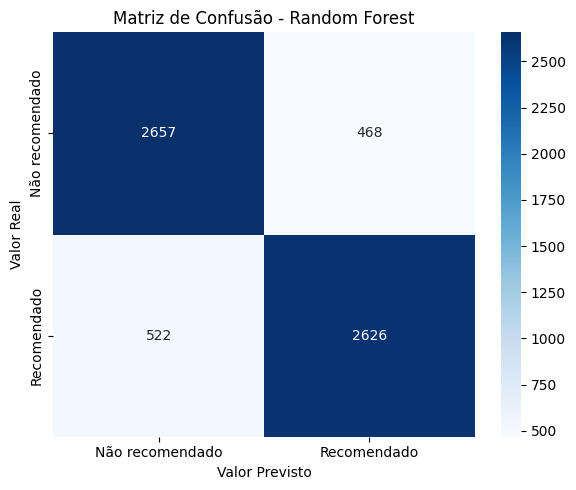

In [ ]:
cm1 = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não recomendado", "Recomendado"],
            yticklabels=["Não recomendado", "Recomendado"])
plt.title("Matriz de Confusão - Random Forest")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

##Modelo número 3: Árvore de decisão

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(data_clean["review_text"])
y = data_clean['is_recommended']

rus = RandomUnderSampler(random_state = 5)
X_resampled, y_resampled = rus.fit_resample(X, y)


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 8)


arvore_decisao = DecisionTreeClassifier(max_depth=10, random_state = 8)
arvore_decisao.fit(X_train, y_train)
predictions = arvore_decisao.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

Accuracy: 0.7289972899728997


In [ ]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.68      0.87      0.76      3125
         1.0       0.82      0.59      0.69      3148

    accuracy                           0.73      6273
   macro avg       0.75      0.73      0.72      6273
weighted avg       0.75      0.73      0.72      6273



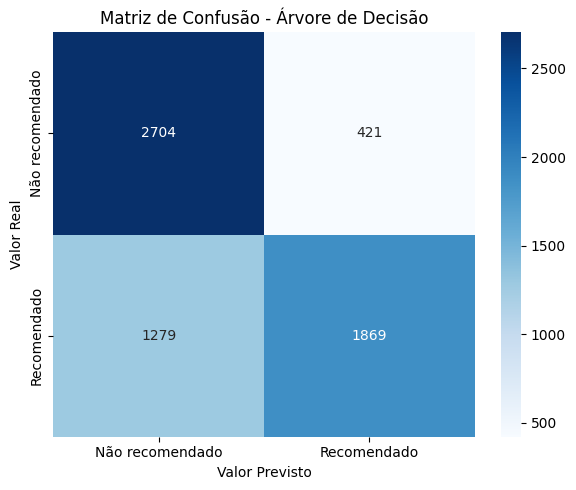

In [ ]:
cm1 = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não recomendado", "Recomendado"],
            yticklabels=["Não recomendado", "Recomendado"])
plt.title("Matriz de Confusão - Árvore de Decisão")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()

##Modelo número 4: KNN (K-Nearest Neighbors)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
vectorizer = TfidfVectorizer(max_features = 5000)
X = vectorizer.fit_transform(data_clean["review_text"])
y = data_clean['is_recommended']

rus = RandomUnderSampler(random_state = 5)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred = knn.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.76      0.76      3133
         1.0       0.76      0.78      0.77      3140

    accuracy                           0.77      6273
   macro avg       0.77      0.77      0.77      6273
weighted avg       0.77      0.77      0.77      6273



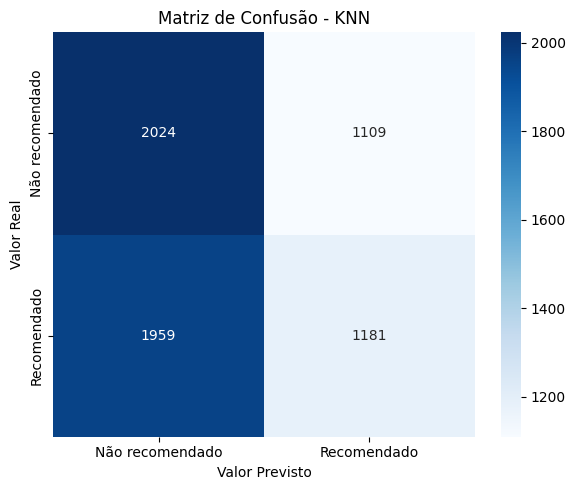

In [ ]:
cm1 = confusion_matrix(y_test, predictions)
plt.figure(figsize=(6, 5))
sns.heatmap(cm1, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Não recomendado", "Recomendado"],
            yticklabels=["Não recomendado", "Recomendado"])
plt.title("Matriz de Confusão - KNN")
plt.xlabel("Valor Previsto")
plt.ylabel("Valor Real")
plt.tight_layout()
plt.show()